# Setup

In [16]:
import os
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neuralgeom"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/nmiolane/code/neuralgeom/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom/neuralgeom


# Imports

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import json

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

import default_config as config
import neuralgeom.datasets.utils as utils
import neuralgeom.models.neural_vae as neural_vae
import train
import viz

In [19]:
# run_ids = "94ad08fb", "cf61cdd2", "cd554607", "0d8c0444"
# 97e13881

# Get config on run of interest

## Specify run ID

In [37]:
#run_id = "97e13881"
run_id = "0ee13a57"

## Load run config

In [38]:
#NINA's

with open(
    f"notebooks/files/run_{run_id}_t2_synthetic_noise_var_0.001_embedding_dim_3.json",
    "r",
) as f:
    config_dict = json.load(f)

# Convert a dict into an object where attributes are accessed with "."
# This is needed for the utils.load() function
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


config = AttrDict(config_dict)

In [39]:
config

{'lr': 0.00029547723794191003,
 'batch_size': 32,
 'encoder_width': 200,
 'encoder_depth': 6,
 'decoder_width': 400,
 'decoder_depth': 10,
 'drop_out_p': 0,
 'dataset_name': 't2_synthetic',
 'sweep_name': 't2_synthetic_noise_var_0.001_embedding_dim_3',
 'expt_id': None,
 'timestep_microsec': None,
 'smooth': None,
 'select_gain_1': None,
 'n_times': 2000,
 'embedding_dim': 3,
 'geodesic_distortion_amp': 0.4,
 'noise_var': 0.001,
 'grid_scale': None,
 'arena_dims': None,
 'n_cells': None,
 'grid_orientation_mean': None,
 'grid_orientation_std': None,
 'field_width': None,
 'resolution': None,
 'manifold_dim': 2,
 'latent_dim': 3,
 'posterior_type': 'toroidal',
 'geodesic_distortion_func': None,
 'n_wiggles': None,
 'radius': None,
 'major_radius': 2,
 'minor_radius': 1,
 'synthetic_rotation': 'identity',
 'device': 'cuda',
 'log_interval': 20,
 'checkpt_interval': 20,
 'batch_shuffle': True,
 'scheduler': False,
 'n_epochs': 1000,
 'alpha': 1.0,
 'beta': 0.001,
 'gamma': 0,
 'gamma_movi

In [23]:
# CONFIG_DIR = os.path.join(os.getcwd(), "results", "configs")

# print(f"Config in directory: {CONFIG_DIR}:")
# for config_file in os.listdir(CONFIG_DIR):
#     if run_id in config_file:
#         print(config_file)
#         run_id_config_file = config_file

# with open(
#     os.path.join(CONFIG_DIR, run_id_config_file),
#     "r",
# ) as f:
#     config_dict = json.load(f)

# # Convert a dict into an object where attributes are accessed with "."
# # This is needed for the utils.load() function
# class AttrDict(dict):
#     def __init__(self, *args, **kwargs):
#         super(AttrDict, self).__init__(*args, **kwargs)
#         self.__dict__ = self


# config = AttrDict(config_dict)

# Get data, model, curvature profile

## Load data

In [24]:
dataset_torch, labels, train_loader, test_loader = utils.load(config)
dataset_torch = dataset_torch.to(config.device)
_, data_dim = dataset_torch.shape

Dataset shape: torch.Size([1936, 3]).


## Load model

In [40]:
# NINA's

model_path = f"notebooks/files/run_{run_id}_t2_synthetic_noise_var_0.001_embedding_dim_3_model.pt"
model = torch.load(model_path)

In [41]:
# trained_models_dir = os.path.join(os.getcwd() + "/results/trained_models")

# model_path = os.path.join(trained_models_dir, f"{config.results_prefix}_model.pt")
# model = torch.load(model_path)

## Get learned immersion $f$ and neural metric

In [42]:
import geomstats.backend as gs
from geomstats.geometry.pullback_metric import PullbackMetric

import evaluate

learned_immersion = evaluate.get_learned_immersion(model, config)

neural_metric = PullbackMetric(
    dim=2, embedding_dim=config.data_dim, immersion=learned_immersion
)

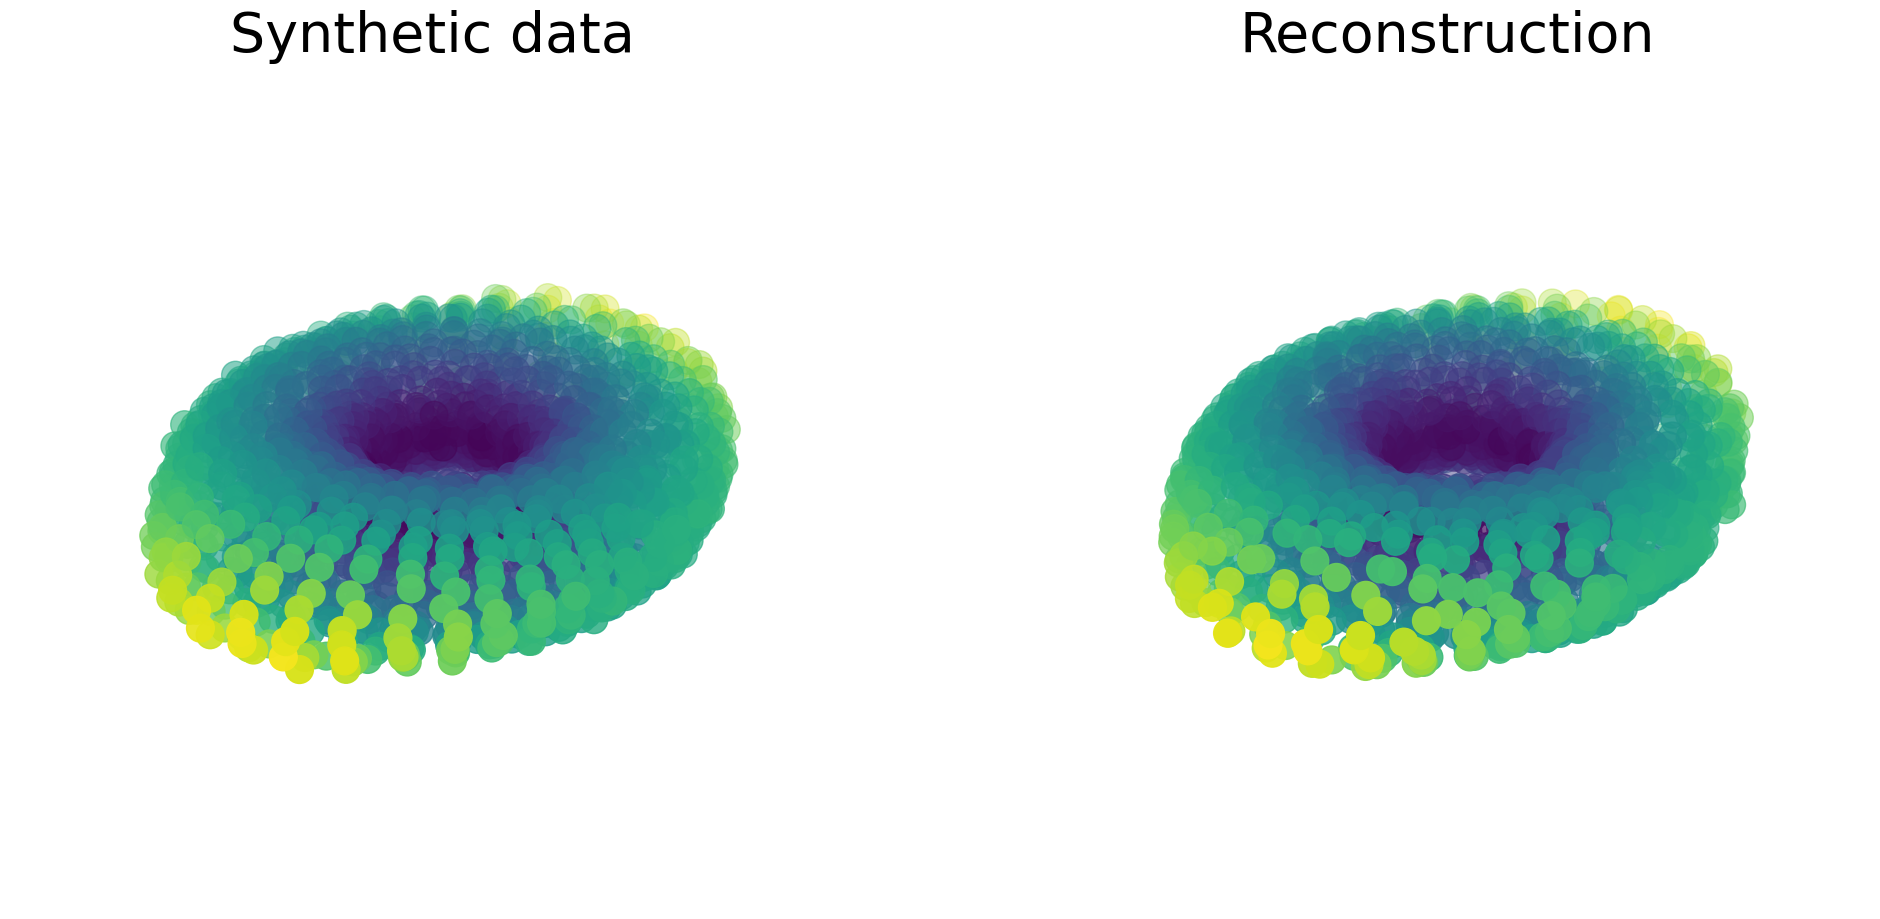

In [43]:
viz.plot_recon_per_positional_angle(model, dataset_torch, labels, config);

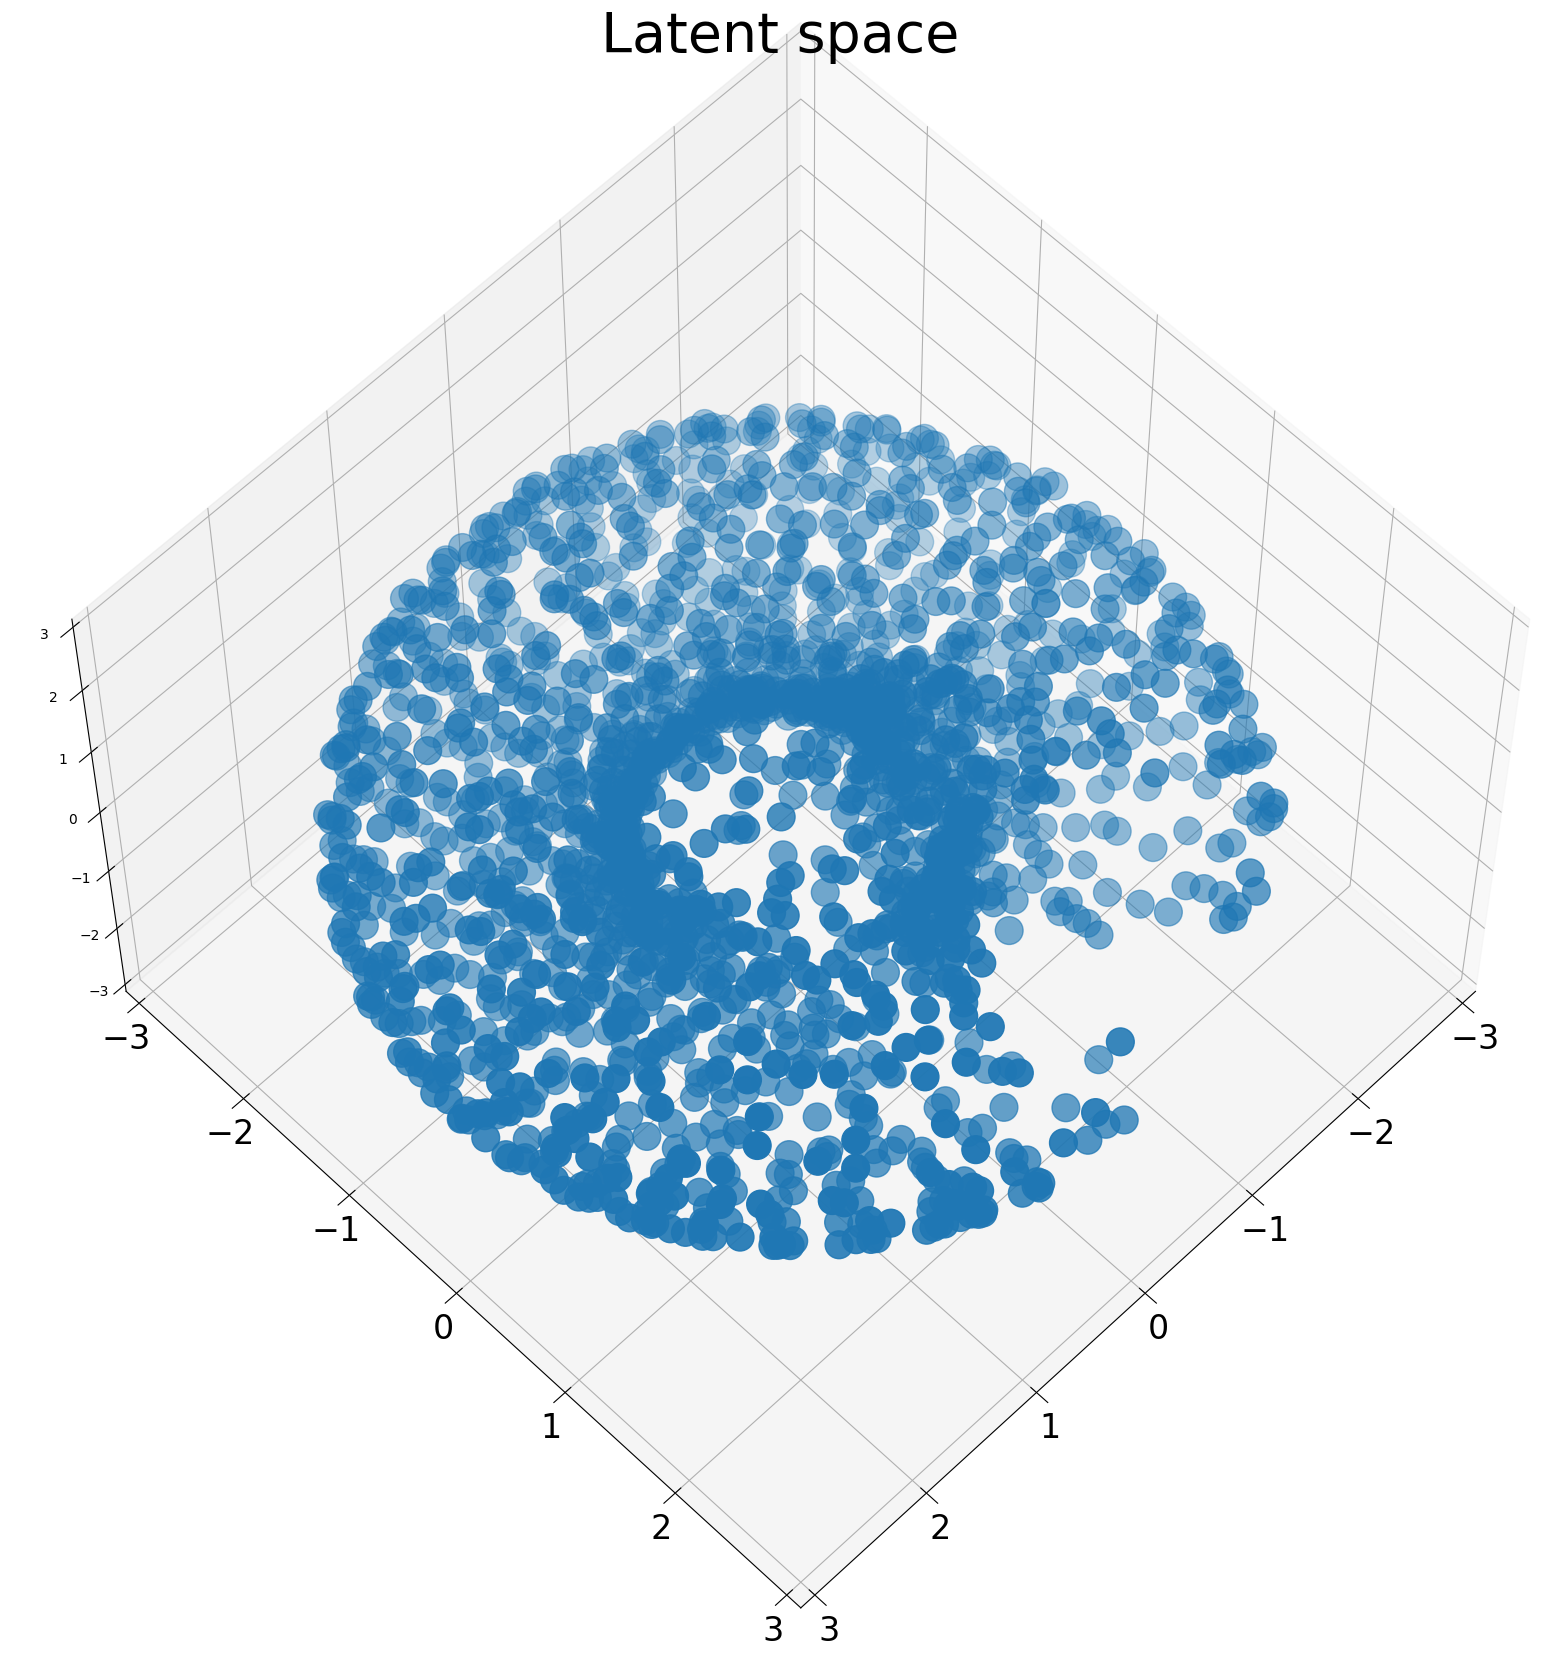

In [44]:
viz.plot_latent_space(model, dataset_torch, labels, config);

## Load learned curvature profile

In [45]:
# # NINA's

# curv_norm_learned_profile = pd.read_csv("notebooks/files/run_97e13881_t2_synthetic_noise_var_0.001_embedding_dim_3_curv_norm_learned_profile.csv"
# )
# curv_norm_learned_profile

In [18]:
# CURVATURE_PROFILES_DIR = os.path.join(os.getcwd(), "results", "curvature_profiles")

# curv_norm_learned_profile = pd.read_csv(
#     os.path.join(
#         CURVATURE_PROFILES_DIR, config.results_prefix + "_curv_norm_learned_profile.csv"
#     )
# )
# curv_norm_learned_profile

# Towards parameterization invariance

## Compute true curvature

In [46]:
true_immersion = evaluate.get_true_immersion(config)
(
    z_grid_true,
    geodesic_dist_true,
    curv_true,
    curv_norms_true,
) = evaluate.compute_curvature_true(config, 100)

Computation time: 2.383 seconds.


## Compute learned curvature

In [49]:
(
    z_grid_learned,
    geodesic_dists_learned,
    curv_learned,
    curv_norms_learned,
) = evaluate.compute_curvature_learned(
    model, config, embedding_dim=3, n_grid_points=1000
)

_LinAlgError: linalg.inv: The diagonal element 2 is zero, the inversion could not be completed because the input matrix is singular.

## Parallel computations of geodesic distances

In [36]:
import time
import copy
import logging

from joblib import Parallel, delayed

model.to("cuda:0")

z_grid_theta = torch.tensor(curv_norm_learned_profile["z_grid_theta"].values) # = pi  # ??
z_grid_phi = torch.tensor(curv_norm_learned_profile["z_grid_phi"].values)  # ??

z0 = gs.array([z_grid_theta[0], z_grid_phi[0]])
#assert z0.shape == (2, 1), z0.shape


# TODO (use logging to actually print and know which iterations we are on)
def _geodesic_dist(i_z_phi, z_phi, grid_interval_phi):
    if i_z_phi == 0:
        return (0, torch.tensor(0.0))

    model_copy = copy.deepcopy(model).to(f"cuda:{i_z_phi % 9}")
    #z_phi = torch.unsqueeze(z_phi, dim=0)
    z_phi_previous = z_grid_phi[i_z_phi - grid_interval_phi]
    start = time.time()

    z = gs.array([z_phi, z_grid_theta[0]])
    z = torch.unsqueeze(z, dim=0)
    assert z.shape == (1, 2), z.shape
    z_previous = gs.array([z_phi_previous, z_grid_theta[0]])
    z_previous = torch.unsqueeze(z_previous, dim=0)
    assert z_previous.shape == (1, 2), z_previous.shape
    print(z.shape, z_previous.shape)
    dist = neural_metric.dist(z_previous[0], z[0], n_steps=7)
    #dist = neural_metric.dist(z_previous, z, n_steps=7)
    duration = time.time() - start
    logging.info(f"Time (it: {i_z_phi}): {duration:.3f}")
    return (i_z_phi, dist)


# To try this code , use z_grid[:5] to run on smaller batch
# Currently, the z_grid is too big (~800) --> go to 100
# Note: each distance computation takes ~5s.
grid_interval_phi = 1
res = Parallel(n_jobs=1)(
    delayed(_geodesic_dist)(i_z_phi, z_phi, grid_interval_phi)
    for i_z_phi, z_phi in enumerate(z_grid_phi[:3])
    if i_z_phi % grid_interval_phi == 0
)

torch.Size([1, 2]) torch.Size([1, 2])


_LinAlgError: linalg.inv: The diagonal element 2 is zero, the inversion could not be completed because the input matrix is singular.

In [23]:
geodesic_dists = torch.zeros(len(res))
curv_norms = torch.zeros(len(res))
for i_z, dist in res:
    geodesic_dists[i_z] = dist
    curv_norms[i_z] = curv_norm_learned_profile["curv_norm_learned"].values[i_z]

print(geodesic_dists[:10])
print(curv_norms[:10])
print(1 / curv_norms[:10])

print(len(geodesic_dists))

NameError: name 'res' is not defined

In [ ]:
cumul_geodesic_dists = torch.cumsum(geodesic_dists, dim=0)
cumul_geodesic_dists[:10]
print(cumul_geodesic_dists.max())

In [8]:
import subprocess

git_branch = subprocess.check_output(["git", "branch"], universal_newlines=True)

In [ ]:
closed_geodesic_dists = torch.concat(
    [cumul_geodesic_dists, torch.tensor([cumul_geodesic_dists[0]])]
)
closed_curv_norms = torch.concat([curv_norms, torch.tensor([curv_norms[0]])])

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

cmaps = ["viridis"]

fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6), subplot_kw={"projection": "polar"}
)

i_zs = [i_z for i_z, _ in res]
subgrid_profile = curv_norm_learned_profile.take(i_zs)

ax.plot(closed_geodesic_dists, closed_curv_norms, c="black")
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
ax.set_title("Color: " + stat_velocities, va="bottom")
fig.tight_layout()
# import os
# print(os.getcwd())
fig.savefig(f"notebooks/figures/run_{run_id}_invariant_manifold.svg")

# Obtain true and learned "shape" of curvature profile

In [1]:
# z_grid_learned, cumul_geodesic_dists_learned, curv_norms_learned = remove_outliers(
#     z_grid_learned, cumul_geodesic_dists_learned, curv_norms_learned
# )

In [ ]:
import scipy


# function to find best alignment
def get_cross_corr(signal1, signal2):
    s1 = np.squeeze(signal1)
    mean_s1 = np.mean(s1)
    s1 = s1 - mean_s1
    s2 = np.squeeze(signal2)
    mean_s2 = np.mean(s2)
    s2 = s2 - mean_s2
    correlation = np.correlate(s1, s2, mode="same")
    lags = scipy.signal.correlation_lags(s1.size, s2.size, mode="same")
    lag = lags[np.argmax(correlation)]
    s1 = np.roll(s1, -lag)
    s1 += mean_s1
    return s1, correlation

## Quotient out global scaling

In [ ]:
scaling_factor = 2 * np.pi / np.max(cumul_geodesic_dists_learned)

rescaled_curv_norms_learned = curv_norms_learned * scaling_factor

rescaled_cumul_geodesic_dists_learned = cumul_geodesic_dists_learned * scaling_factor

## Quotient out global rotation

In [ ]:
# ensures that the true profile and the learned profile are sampled at the same points
curv_norms_true_interp = np.interp(
    rescaled_cumul_geodesic_dists_learned, z_grid_true, curv_norms_true
)

# computes cross-correlation between true and learned curvature profiles, returns offset of best alignment
aligned_curv_norms_learned, correlation = get_cross_corr(
    rescaled_curv_norms_learned, curv_norms_true_interp
)

## Plot curvature shapes

In [ ]:
smoothing = False

fig = plt.figure(figsize=(15, 5))
ax_no_geodesic = fig.add_subplot(121)
curv_norms_learned, _ = get_cross_corr(curv_norms_learned, curv_norms_true)

ax_no_geodesic.plot(
    z_grid_true, curv_norms_true, label="True", dashes=[5, 2], linewidth=3
)
ax_no_geodesic.plot(z_grid_learned, curv_norms_learned, label="Learned", linewidth=3)
ax_no_geodesic.legend()
ax_no_geodesic.set_xlabel("Angle")
ax_no_geodesic.set_ylabel("Magnitude of mean curvature")
ax_no_geodesic.set_title("Learned curvature profile")


ax_geodesic = fig.add_subplot(122)

if smoothing:
    aligned_curv_norms_learned = scipy.signal.savgol_filter(
        aligned_curv_norms_learned, window_length=15, polyorder=7
    )

ax_geodesic.plot(
    rescaled_cumul_geodesic_dists_learned,
    curv_norms_true_interp,
    label="True",
    dashes=[5, 2],
    linewidth=3,
)
ax_geodesic.plot(
    rescaled_cumul_geodesic_dists_learned,
    aligned_curv_norms_learned,
    label="Learned",
    linewidth=3,
)
ax_geodesic.legend()
ax_geodesic.set_xlabel("Angle")
ax_geodesic.set_ylabel("Magnitude of mean curvature")
ax_geodesic.set_title("Parameterization-invariant learned curvature profile")

CURVATURE_SHAPES_DIR = os.path.join(os.getcwd(), "results", "curvature_shapes")

plt.savefig(
    os.path.join(CURVATURE_SHAPES_DIR, f"param_inv_s1_run_id_{run_id}_profile.png")
)
plt.savefig(
    os.path.join(CURVATURE_SHAPES_DIR, f"param_inv_s1_run_id_{run_id}_profile.svg")
)

## Plot curvature shapes, polar

In [ ]:
error_no_geodesic = evaluate._compute_curvature_error_s1(
    z_grid_true, curv_norms_learned, curv_norms_true
)
error_geodesic = evaluate._compute_curvature_error_s1(
    rescaled_cumul_geodesic_dists_learned,
    aligned_curv_norms_learned,
    curv_norms_true_interp,
)


fig_polar = plt.figure(figsize=(15, 15))
ax_polar_no_geodesic = fig_polar.add_subplot(121, projection="polar")
ax_polar_no_geodesic.plot(
    z_grid_true,
    0.5 + curv_norms_true,
    label="True",
    dashes=[5, 2],
    linewidth=3,
    color="dodgerblue",
)
ax_polar_no_geodesic.plot(
    z_grid_learned,
    0.5 + curv_norms_learned,
    label="Learned",
    linewidth=3,
    color="orangered",
)
ax_polar_no_geodesic.set_title(
    "Learned curvature profile. Error = " + "{:.3f}".format(error_no_geodesic)
)
ax_polar_no_geodesic.set_rticks([1])
ax_polar_no_geodesic.legend(
    bbox_to_anchor=(1.05, 1), loc="upper right", borderaxespad=0
)


ax_polar_geodesic = fig_polar.add_subplot(122, projection="polar")
ax_polar_geodesic.plot(
    rescaled_cumul_geodesic_dists_learned,
    0.5 + curv_norms_true_interp,
    label="True",
    dashes=[5, 2],
    linewidth=3,
    color="dodgerblue",
)
ax_polar_geodesic.plot(
    rescaled_cumul_geodesic_dists_learned,
    0.5 + aligned_curv_norms_learned,
    label="Learned",
    linewidth=3,
    color="limegreen",
)
ax_polar_geodesic.set_title(
    "Parameterization-invariant learned curvature profile. Error = "
    + "{:.3f}".format(error_geodesic)
)
ax_polar_geodesic.set_rticks([1])
ax_polar_geodesic.legend(bbox_to_anchor=(1.05, 1), loc="upper right", borderaxespad=0)

plt.savefig(
    os.path.join(
        CURVATURE_SHAPES_DIR, f"param_inv_s1_run_id_{run_id}_profile_polar.png"
    )
)
plt.savefig(
    os.path.join(
        CURVATURE_SHAPES_DIR, f"param_inv_s1_run_id_{run_id}_profile_polar.svg"
    )
)